Metro PT Reduced Dataset

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pyarrow
import warnings
import fastparquet
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

Data reduction


In [16]:
# import os
# import time

# # --- Configuration ---
# INPUT_FILE = 'metropt_data/dataset_train.csv' 
# OUTPUT_FILE = 'downsampled_10s_data.csv'
# INTERVAL = 10  # Keep data every N seconds

# print(f"Starting downsampling process for {INPUT_FILE}...")
# start_time = time.time()

# # 1. Check if the file exists
# if not os.path.exists(INPUT_FILE):
#     print(f"🚨 ERROR: Input file '{INPUT_FILE}' not found. Please check the file name and path.")
# else:
#     try:
#         # 2. Read the entire CSV file into a pandas DataFrame
#         # For an 8 million row CSV, this is usually acceptable, but if you hit
#         # a MemoryError, see the "Advanced Memory Tip" section below.
#         df = pd.read_csv(INPUT_FILE)
        
#         original_rows = len(df)
#         print(f"✅ Data loaded. Original rows: {original_rows:,}")
        
#         # 3. Downsample the data using iloc (integer-location based indexing)
#         # The slice [::INTERVAL] selects the 1st, 11th, 21st, 31st, etc., row (index 0, 10, 20, 30...)
#         df_downsampled = df.iloc[::INTERVAL, :].copy()
        
#         downsampled_rows = len(df_downsampled)

#         # 4. Save the reduced DataFrame to a new CSV file
#         df_downsampled.to_csv(OUTPUT_FILE, index=False)
        
#         # --- Summary Output ---
#         end_time = time.time()
#         time_taken = end_time - start_time
        
#         print("\n--- Downsampling Complete ---")
#         print(f"Original Rows: {original_rows:,}")
#         print(f"Downsampled Rows: {downsampled_rows:,}")
#         print(f"Reduction Factor: ~{original_rows / downsampled_rows:.1f}x")
#         print(f"New file saved: **{OUTPUT_FILE}**")
#         print(f"Time taken: {time_taken:.2f} seconds")
        
#     except Exception as e:
#         print(f"An error occurred during processing: {e}")

In [17]:
# -----------------------------------------------------------------
# CHANGE THIS LINE ONLY
CSV_FOLDER = Path("metropt_data")      # <-- folder with your CSV(s)
# -----------------------------------------------------------------

# Verify the folder exists
if not CSV_FOLDER.exists():
    raise FileNotFoundError(f"Folder not found: {CSV_FOLDER}")

# Find every .csv (even in sub‑folders)
csv_files = sorted(CSV_FOLDER.rglob("*.csv"))
print(f"Found {len(csv_files)} CSV file(s):")
for p in csv_files:
    print("  •", p.name)

Found 3 CSV file(s):
  • dataset_train.csv
  • dataset_train_ORG.csv
  • downsampled_10s_data.csv


In [18]:
# --------------------------------------------------------------
# 1. SETTINGS
CSV_FILE     = Path("metropt_data") / "downsampled_10s_data.csv"
OUT_PARQUET  = Path("metropt_clean.parquet")
CHUNK_SIZE   = 500_000
# --------------------------------------------------------------

# 2. Columns to keep
USE_COLS = [
    'timestamp', 'TP2', 'TP3', 'DV_pressure', 'Reservoirs',
    'Oil_temperature', 'Flowmeter', 'Motor_current',
    'Caudal_impulses', 'gpsSpeed', 'Pressure_switch',
    'Oil_level', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'gpsQuality'
]

# 3. Target dtypes
NUMERIC_COLS = [
    'TP2', 'TP3', 'DV_pressure', 'Reservoirs',
    'Oil_temperature', 'Flowmeter', 'Motor_current',
    'Caudal_impulses', 'gpsSpeed'
]
CAT_COLS = ['Pressure_switch', 'Oil_level', 'COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'gpsQuality']

# --------------------------------------------------------------
print(f"Processing {CSV_FILE.name} …")

# Install fastparquet if missing
try:
    import fastparquet
except ImportError:
    print("Installing fastparquet...")
    import subprocess, sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "fastparquet", "-q"])
    import fastparquet

first_chunk = True
chunk_iter = pd.read_csv(
    CSV_FILE,
    parse_dates=['timestamp'],
    usecols=USE_COLS,
    chunksize=CHUNK_SIZE,
    low_memory=False,
    dtype={col: 'float64' for col in NUMERIC_COLS}
)

for j, chunk in enumerate(chunk_iter, 1):
    chunk['train_id'] = 1

    # --- Clean numeric ---
    for col in NUMERIC_COLS:
        if col in chunk.columns:
            chunk[col] = pd.to_numeric(chunk[col], errors='coerce').astype('float32')

    # --- Clean category ---
    for col in CAT_COLS:
        if col in chunk.columns:
            chunk[col] = chunk[col].astype('category')

    # Drop rows with no sensor data
    chunk.dropna(how='all', subset=NUMERIC_COLS, inplace=True)

    # --- Write with fastparquet ONLY ---
    chunk.to_parquet(
        OUT_PARQUET,
        engine='fastparquet',
        compression='gzip',
        index=False,
        append=not first_chunk,
        # write_statistics=True
    )
    if first_chunk:
        first_chunk = False
    print(f"  • chunk {j} → {len(chunk):,} rows", end='\r')

print(f"\nDone! Saved → {OUT_PARQUET}")

Processing downsampled_10s_data.csv …
  • chunk 2 → 342,697 rows
Done! Saved → metropt_clean.parquet


In [19]:
metro = pd.read_parquet(OUT_PARQUET, engine='fastparquet')
print(f"Loaded: {metro.shape}")
metro.head()

Loaded: (842697, 19)


,timestamp,TP2,TP3,DV_pressure,Reservoirs,Oil_temperature,Flowmeter,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,gpsSpeed,gpsQuality,train_id
0,2022-01-01 06:00:00,-0.012,9.758,-0.028,1.576,63.349998,19.049625,3.9550,1,0,1,1,0,0,0,0.0,0.0,1,1
1,2022-01-01 06:00:10,-0.012,9.750,-0.028,1.576,62.924999,19.049625,4.0050,1,0,1,1,0,0,0,0.0,0.0,1,1
2,2022-01-01 06:00:20,-0.010,9.740,-0.028,1.576,62.674999,19.049625,4.0225,1,0,1,1,0,0,0,0.0,0.0,1,1
3,2022-01-01 06:00:30,-0.010,9.728,-0.028,1.576,62.375000,19.049625,3.9275,1,0,1,1,0,0,0,0.0,0.0,1,1
4,2022-01-01 06:00:40,-0.012,9.718,-0.028,1.576,62.099998,19.049625,3.9250,1,0,1,1,0,0,0,0.0,0.0,1,1


In [20]:
metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 842697 entries, 0 to 842696
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   timestamp        842697 non-null  datetime64[ns]
 1   TP2              842697 non-null  float32       
 2   TP3              842697 non-null  float32       
 3   DV_pressure      842697 non-null  float32       
 4   Reservoirs       842697 non-null  float32       
 5   Oil_temperature  842697 non-null  float32       
 6   Flowmeter        842697 non-null  float32       
 7   Motor_current    842697 non-null  float32       
 8   COMP             842697 non-null  category      
 9   DV_eletric       842697 non-null  category      
 10  Towers           842697 non-null  category      
 11  MPG              842697 non-null  category      
 12  LPS              842697 non-null  category      
 13  Pressure_switch  842697 non-null  category      
 14  Oil_level        842

In [21]:
# Missing values
missing = metro.isnull().mean().round(4) * 100
missing = missing[missing > 0].sort_values(ascending=False)
print("\nMissing % per column: ",missing)

# Forward‑fill (1‑second sampling → safe)
metro.ffill(inplace=True)


Missing % per column:  Series([], dtype: float64)


In [22]:
cat_map = {
    'Pressure_switch': 'category',
    'Oil_level'      : 'category',
    'COMP'           : 'category',
    'DV_eletric'     : 'category',
    'Towers'         : 'category',
    'MPG'            : 'category',
    'LPS'            : 'category',
    'gpsQuality'     : 'category'
}

for col, dtype in cat_map.items():
    if col in metro.columns:
        metro[col] = metro[col].astype(dtype)

In [23]:
coverage = (metro.groupby('train_id')['timestamp']
            .agg(['min','max'])
            .assign(days=lambda x: (x['max']-x['min']).dt.days))
coverage.head(10)

,min,max,days
train_id,,,
1,2022-01-01 06:00:00,2022-04-30 23:59:59,119


In [24]:
# Core physical sensors (the ones that usually degrade)
sensor_cols = [
    'TP2', 'TP3', 'DV_pressure', 'Reservoirs', 'Oil_temperature',
    'Flowmeter', 'Motor_current', 'Caudal_impulses',
    'gpsSpeed'                     # operational context
]

# Keep only existing columns
sensor_cols = [c for c in sensor_cols if c in metro.columns]
print("Using sensors:", sensor_cols)

metro[sensor_cols].describe().T.round(2)

Using sensors: ['TP2', 'TP3', 'DV_pressure', 'Reservoirs', 'Oil_temperature', 'Flowmeter', 'Motor_current', 'Caudal_impulses', 'gpsSpeed']


,count,mean,std,min,25%,50%,75%,max
TP2,842697.0,1.11,3.02,-0.03,-0.01,-0.01,-0.00,10.83
TP3,842697.0,8.97,0.72,0.01,8.49,8.99,9.50,10.39
DV_pressure,842697.0,-0.02,0.17,-0.04,-0.03,-0.03,-0.03,8.18
Reservoirs,842697.0,1.59,0.08,1.35,1.49,1.62,1.65,2.05
Oil_temperature,842697.0,67.25,5.53,18.70,63.60,68.22,71.12,97.90
Flowmeter,842697.0,20.34,3.74,18.83,19.00,19.03,19.11,39.25
Motor_current,842697.0,2.30,2.20,-0.01,0.00,3.69,3.83,9.19
Caudal_impulses,842697.0,0.00,0.04,0.00,0.00,0.00,0.00,1.00
gpsSpeed,842697.0,6.27,12.68,0.00,0.00,0.00,2.00,167.00


Statistical anomaly rate: 0.757%


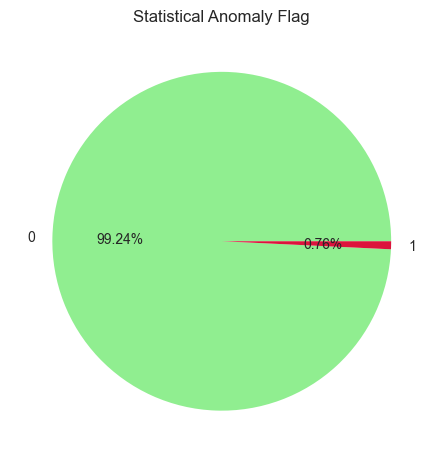

In [25]:
# Z-score per train
metro['z_current'] = metro.groupby('train_id')['Motor_current'].transform(
    lambda x: (x - x.mean()) / x.std()
)
metro['z_oil'] = metro.groupby('train_id')['Oil_temperature'].transform(
    lambda x: (x - x.mean()) / x.std()
)

metro['anomaly_flag'] = ((metro['z_current'].abs() > 3) |
                         (metro['z_oil'].abs() > 3)).astype(int)

rate = metro['anomaly_flag'].mean()*100
print(f"Statistical anomaly rate: {rate:.3f}%")

metro['anomaly_flag'].value_counts(normalize=True).plot.pie(
    autopct='%1.2f%%', colors=['lightgreen','crimson'])
plt.title('Statistical Anomaly Flag')
plt.ylabel('')
plt.show()

In [26]:
# For now: assume a maintenance event occurs right after a statistical anomaly
metro['maintenance_event'] = metro['anomaly_flag'].shift(1).fillna(0).astype(int)
metro['maintenance_event'] = metro['maintenance_event'].astype('category')

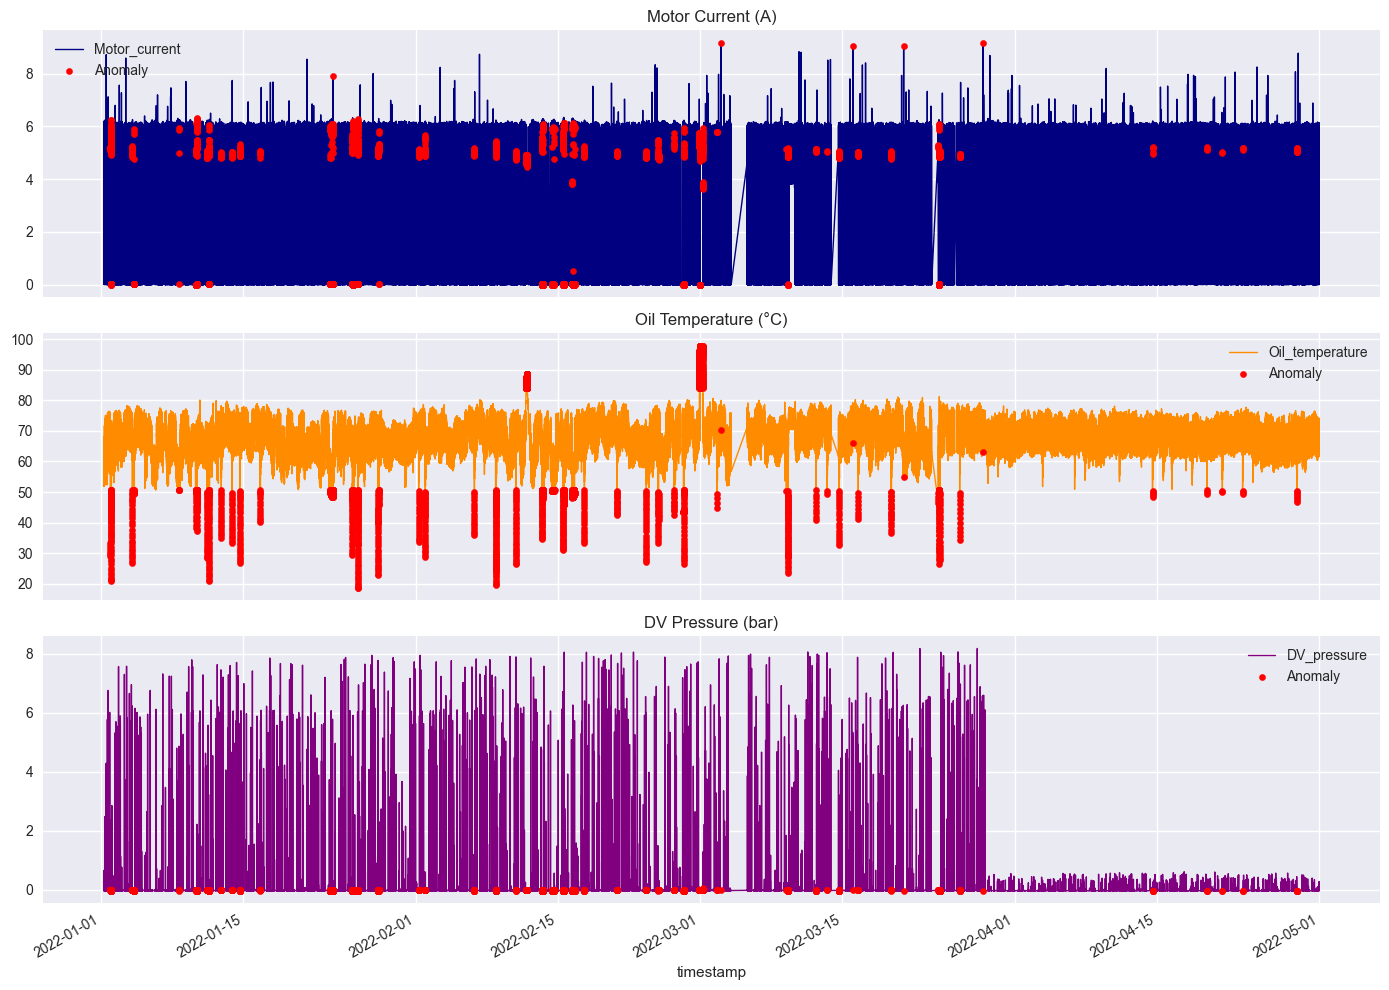

In [27]:
# --- Cell 10: Time-series snapshot (first train) ---
train_id = metro['train_id'].unique()[0]
train_df = metro[metro['train_id'] == train_id].set_index('timestamp')

# Define which sensor goes to which subplot
plot_sensors = ['Motor_current', 'Oil_temperature', 'DV_pressure']
titles = ['Motor Current (A)', 'Oil Temperature (°C)', 'DV Pressure (bar)']
colors = ['navy', 'darkorange', 'purple']

fig, ax = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

for i, (sensor, title, color) in enumerate(zip(plot_sensors, titles, colors)):
    train_df[sensor].plot(ax=ax[i], title=title, color=color, linewidth=1)

# Highlight statistical anomalies
if 'anomaly_flag' in train_df.columns:
    anoms = train_df[train_df['anomaly_flag'] == 1]
    for i, sensor in enumerate(plot_sensors):
        if sensor in anoms.columns:
            ax[i].scatter(anoms.index, anoms[sensor],
                          color='red', s=20, label='Anomaly', zorder=5)
        ax[i].legend()

plt.tight_layout()
plt.show()

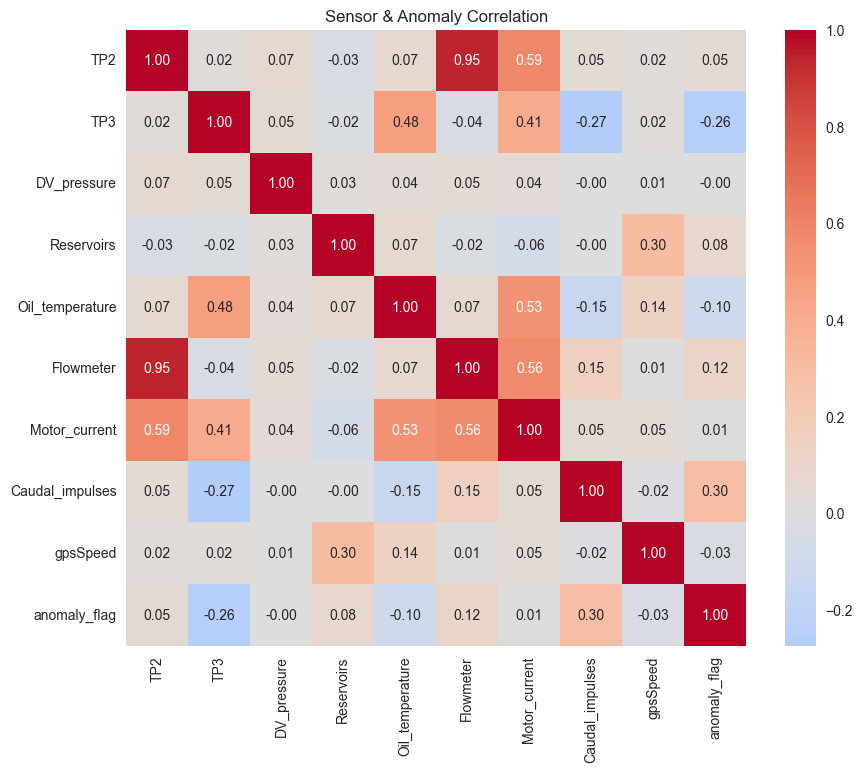

In [28]:
corr_cols = sensor_cols + ['anomaly_flag']
corr = metro[corr_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Sensor & Anomaly Correlation')
plt.show()

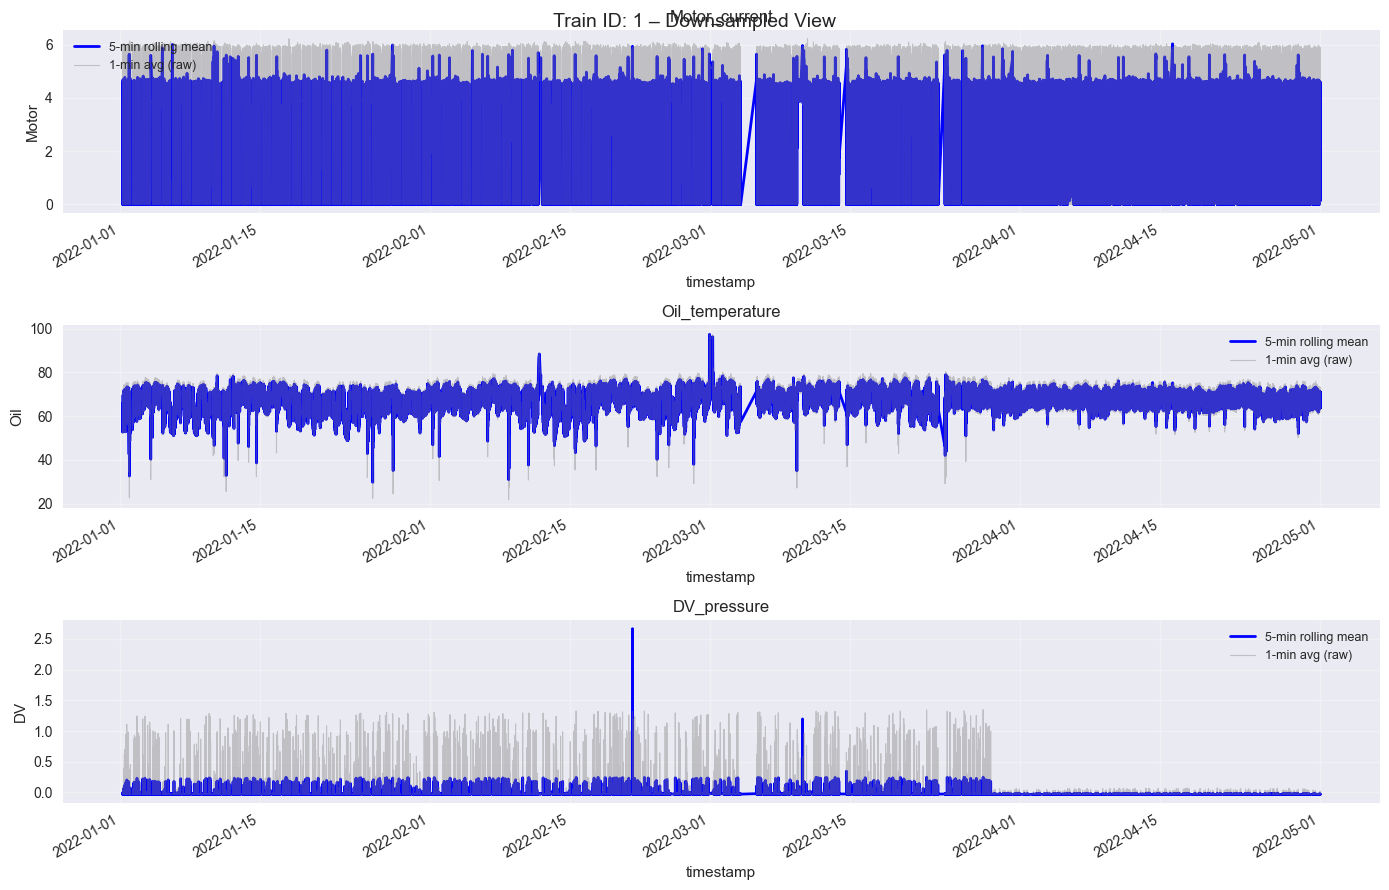

In [29]:
# --- Cell 12: Memory-safe 5-min rolling + downsampled raw plot ---
window = '5T'  # 5 minutes
example_train_id = metro['train_id'].unique()[0]
example_df = metro[metro['train_id'] == example_train_id].set_index('timestamp')

# Use only 3 key sensors to avoid clutter
plot_sensors = ['Motor_current', 'Oil_temperature', 'DV_pressure']

# --- Downsample raw data for plotting (1 point per minute) ---
raw_plot = example_df[plot_sensors].resample('1T').mean()  # 1-minute average

# --- Compute rolling mean on full data (fast) ---
roll = example_df[plot_sensors].rolling(window).mean()

plt.figure(figsize=(14, 9))
for i, sensor in enumerate(plot_sensors, 1):
    plt.subplot(3, 1, i)
    
    # Plot rolling mean (full resolution)
    roll[sensor].plot(label='5-min rolling mean', color='blue', linewidth=2)
    
    # Plot downsampled raw data (light & fast)
    raw_plot[sensor].plot(alpha=0.4, color='gray', linewidth=0.8, label='1-min avg (raw)')
    
    plt.title(f'{sensor}', fontsize=12)
    plt.ylabel(sensor.split('_')[0])
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle(f"Train ID: {example_train_id} – Downsampled View", fontsize=14, y=0.98)
plt.show()

In [30]:
LEAD_MIN = 60
metro = metro.sort_values(['train_id','timestamp'])

metro['future_anomaly'] = metro.groupby('train_id')['anomaly_flag'].shift(-LEAD_MIN)
metro['anomaly_ahead']   = metro['future_anomaly'].fillna(0).astype(int)

rate = metro['anomaly_ahead'].mean()*100
print(f"Positive samples (anomaly within {LEAD_MIN} min): {rate:.3f}%")

Positive samples (anomaly within 60 min): 0.757%


In [31]:
# --- FINAL SAVE (SAFE) ---
clean_path = "metropt_clean.parquet"

# Reset index if it's timestamp or messed up
if metro.index.name == 'timestamp' or not metro.index.is_monotonic_increasing:
    metro = metro.reset_index(drop=False)  # keep timestamp as column
    print("Index reset to ensure monotonic order.")

# Save with fastparquet (avoids pyarrow bugs)
metro.to_parquet(
    clean_path,
    engine='fastparquet',   # <-- use fastparquet, not pyarrow
    compression='gzip',
    index=True              # safe: index is now clean
)

print(f"Saved cleaned data → {clean_path}")

Saved cleaned data → metropt_clean.parquet


In [32]:
# # Example: create windowed features
# def create_window_features(df, win_min=5):
#     win = f"{win_min}T"
#     sensor_stats = df[sensor_cols].rolling(win).agg(['mean','std','min','max','skew'])
#     sensor_stats.columns = ['_'.join(col) for col in sensor_stats.columns]
#     return sensor_stats

# # Apply per train
# windowed = (metro.groupby('train_id')
#             .apply(create_window_features)
#             .reset_index())

In [33]:
# --------------------------------------------------------------
# 1. LOAD CLEAN DATA
# --------------------------------------------------------------
metro = pd.read_parquet("metropt_clean.parquet", engine='fastparquet')
print(f"Loaded: {metro.shape[0]:,} rows, {metro.shape[1]} cols")
print(f"Time range: {metro['timestamp'].min()} → {metro['timestamp'].max()}")

Loaded: 842,697 rows, 25 cols
Time range: 2022-01-01 06:00:00 → 2022-04-30 23:59:59


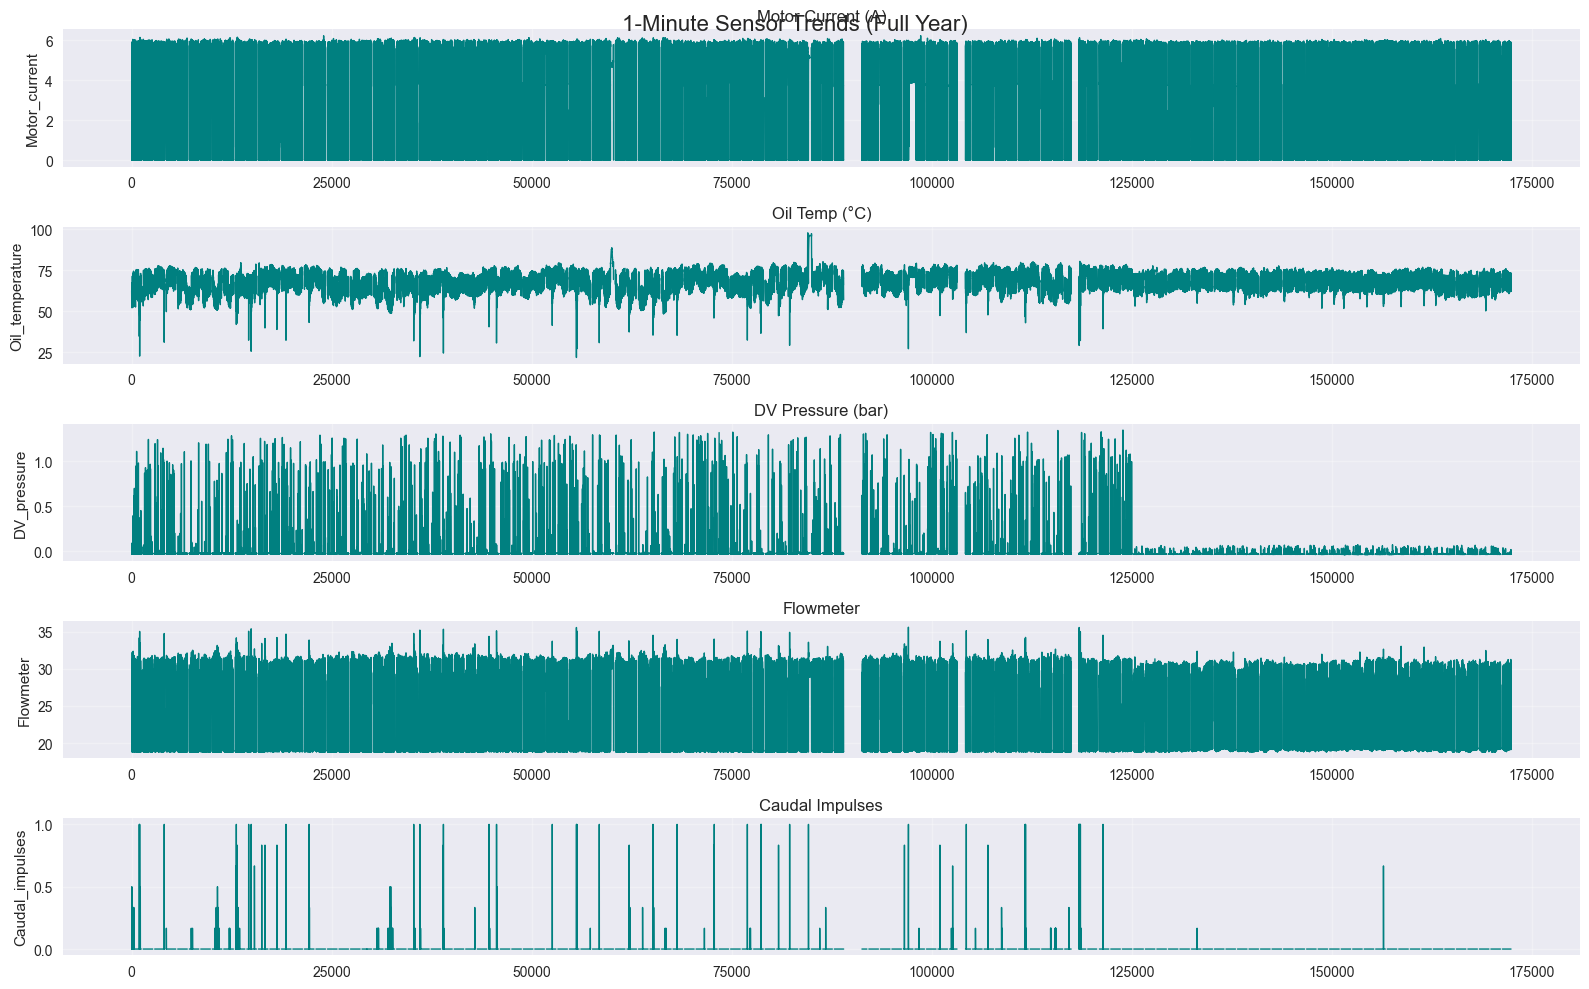

In [34]:
# Downsample to 1-minute for smooth plots
df = metro.set_index('timestamp').resample('1T').mean(numeric_only=True).reset_index()
df['train_id'] = 1

# Key sensors
sensors = ['Motor_current', 'Oil_temperature', 'DV_pressure', 'Flowmeter', 'Caudal_impulses']
titles  = ['Motor Current (A)', 'Oil Temp (°C)', 'DV Pressure (bar)', 'Flowmeter', 'Caudal Impulses']

plt.figure(figsize=(16, 10))
for i, (col, title) in enumerate(zip(sensors, titles), 1):
    plt.subplot(len(sensors), 1, i)
    df[col].plot(color='teal', linewidth=1)
    plt.title(title, fontsize=12)
    plt.ylabel(col)
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.suptitle("1-Minute Sensor Trends (Full Year)", fontsize=16, y=0.98)
plt.show()

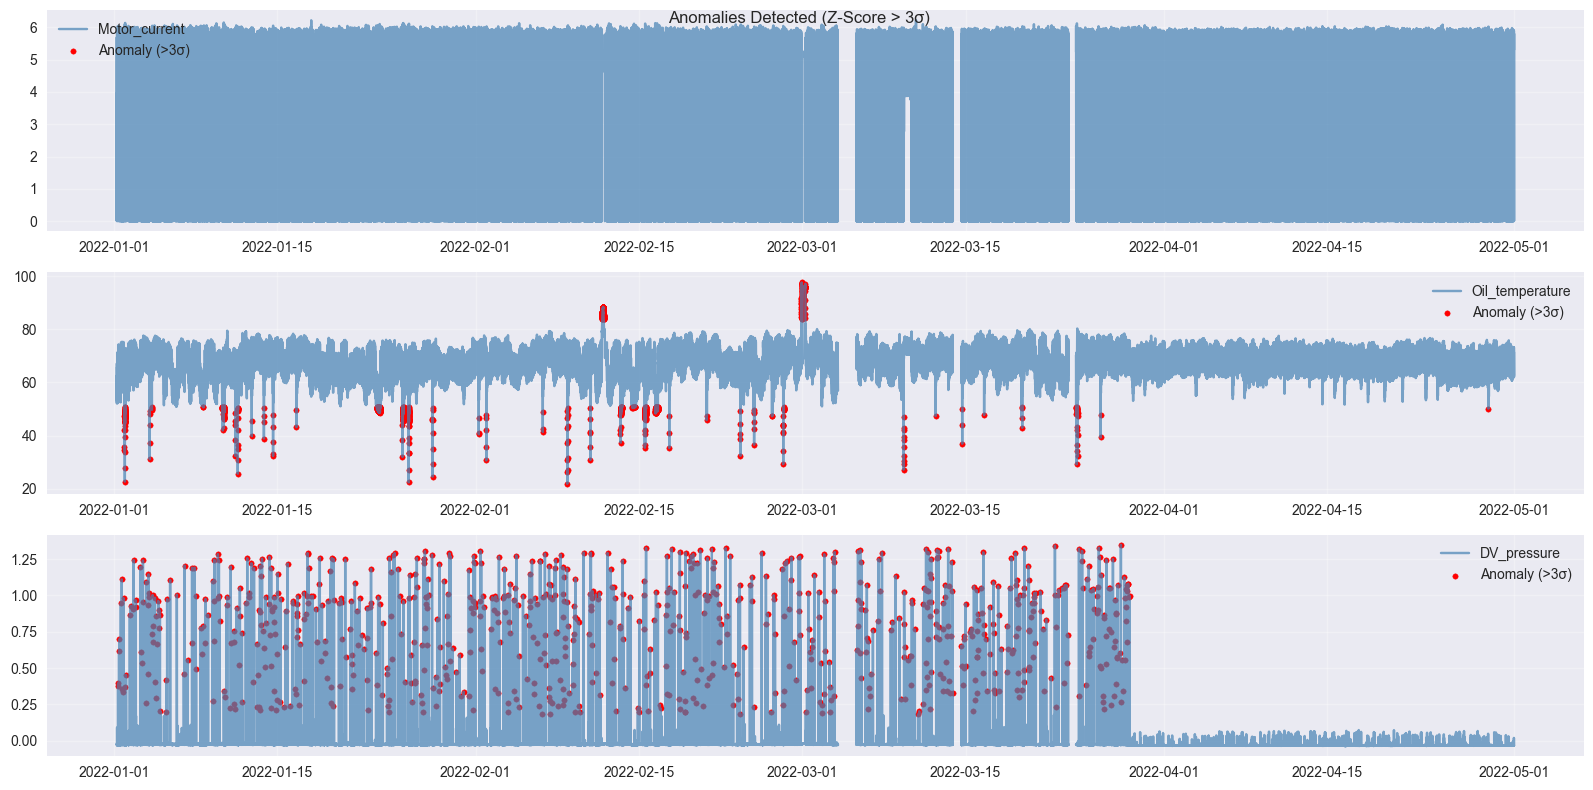

Anomaly counts (>3σ):
  Motor_current: 0 (0.000%)
  Oil_temperature: 1,090 (0.632%)
  DV_pressure: 845 (0.490%)
  Flowmeter: 5,617 (3.257%)
  Caudal_impulses: 367 (0.213%)


In [35]:
# Z-score per sensor (robust to trends)
from scipy import stats

df_plot = df.copy()
for col in sensors:
    df_plot[f'{col}_z'] = stats.zscore(df_plot[col], nan_policy='omit')
    df_plot[f'anom_{col}'] = (df_plot[f'{col}_z'].abs() > 3)

# Plot anomalies
plt.figure(figsize=(16, 8))
for i, col in enumerate(sensors[:3], 1):  # Top 3
    plt.subplot(3, 1, i)
    plt.plot(df_plot['timestamp'], df_plot[col], label=col, color='steelblue', alpha=0.7)
    anom = df_plot[df_plot[f'anom_{col}']]
    plt.scatter(anom['timestamp'], anom[col], color='red', s=15, label='Anomaly (>3σ)')
    plt.legend()
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.suptitle("Anomalies Detected (Z-Score > 3σ)", y=0.98)
plt.show()

# Count anomalies
anom_counts = {col: df_plot[f'anom_{col}'].sum() for col in sensors}
print("Anomaly counts (>3σ):")
for k, v in anom_counts.items():
    print(f"  {k}: {v:,} ({v/len(df_plot)*100:.3f}%)")

In [36]:
# Use 5-minute windows on FULL 1-second data
window = '5T'
roll = metro.set_index('timestamp').rolling(window)

features = pd.DataFrame(index=metro.index)

# Rolling stats
for col in sensors:
    features[f'{col}_mean'] = roll.mean()[col]
    features[f'{col}_std']  = roll.std()[col]
    features[f'{col}_min']  = roll.min()[col]
    features[f'{col}_max']  = roll.max()[col]
    features[f'{col}_range'] = features[f'{col}_max'] - features[f'{col}_min']

# Slope (trend over last 30 min)
slope_window = '30T'
for col in sensors:
    features[f'{col}_slope'] = (
        roll[col].mean().diff(periods=6)  # 30 min / 5 min = 6 steps
    )

# Add time features
features['hour'] = metro['timestamp'].dt.hour
features['dayofweek'] = metro['timestamp'].dt.dayofweek
features['month'] = metro['timestamp'].dt.month

# Reset index
features = features.reset_index()
features['train_id'] = 1

print(f"Generated {features.shape[1]} features")

Generated 35 features
